In [95]:
import sys
# sys.path.append(r'C:\Users\ruro\OneDrive - Boskalis\Documents\python\ADV')
import os
import numpy as np
import xarray as xr
import puv
from KNMI_readers import read_knmi_uurgeg


In [96]:
# general settings

# location of knmi file (to correct for air pressure drift during the experiment)
knmiFile = r"C:\Users\ruro\OneDrive - Boskalis\Documents\python\Hybrid_Dune\Pressure_sensors\uurgeg_330_2021-2030.txt"


# number of the knmi station (to make sure the correction is done with the correct KNMI station)
stationNumber = 330
# height of instrument above bed
hi = 0.57 #m
# height of instruments pressure sensor above bed
hip = 0.27 #m
# bed level
zb = 0 #m NAP
# angle of x-pod of the vector head with respect to north (clockwise positive)
thet = 0 # degrees
# density of water
rho = 1025 # kg/m3
# gravitational acceleration
g = 9.81 # m/s2

#################################
# experimentFolder= r'C:\Users\ruro\OneDrive - Boskalis\Documents\python\ADV'
# instrument = 'vec1_pilot'
# dataFile = os.path.join(experimentFolder, '\raw_netcdf', instrument + '.nc' )
# ds = xr.open_dataset(dataFile)


In [97]:
import pandas as pd

# parameters for the quality control:
QC = {
     'uLim':2.1, #maximum acceptable recorded u-velocity
     'vLim':2.1, #maximum acceptable recorded v-velocity
     'wLim':0.6, #maximum acceptable recorded w-velocity
     'corTreshold':70, #minimum correlation
     'maxFracNans': 0.02, #maximum fraction of rejected pings in the sample to proceed with processing based on interpolation
     'maxGap' : 4 #maximum amount of sequential rejected pings in the sample to proceed with processing based on interpolation
      }

## load the data
ds = xr.open_dataset(r"C:\Users\ruro\OneDrive - Boskalis\Documents\python\Hybrid_Dune\ADV\Deployment 1, until 23dec\raw_netcdf\ADV_RWS1_Deployment1_pilot.nc")

# % add some data to the dataset
ds['zb'] = zb

ds['zi'] = ds['zb'] + hi
ds['zi'].attrs = {'units': 'm+NAP', 'long_name': 'position probe'}

ds['zip'] = ds['zb'] + hip
ds['zip'].attrs = {'units': 'm+NAP', 'long_name': 'position pressure sensor'}

ds['rho'] = rho
ds['rho'].attrs = {'units': 'kg/m3', 'long_name': 'water density'}

ds['g'] = g
ds['g'].attrs = {'units': 'm', 'long_name': 'gravitational acceleration'}

# if correlation is outside confidence range
mc1 = ds.cor1 > QC['corTreshold']
mc2 = ds.cor2 > QC['corTreshold']
mc3 = ds.cor3 > QC['corTreshold']

# if observation is outside of velocity range
mu1 = np.abs(ds.u) < QC['uLim']
mu2 = np.abs(ds.v) < QC['uLim']
mu3 = np.abs(ds.w) < QC['uLim']

# if du larger than 4*std(u) then we consider it outlier and hence remove:
md1 = np.abs(ds.u.diff('N')) < 3 * ds.u.std(dim='N')
md1 = md1.combine_first(mu1)
md2 = np.abs(ds.v.diff('N')) < 3 * ds.v.std(dim='N')
md2 = md1.combine_first(mu2)
md3 = np.abs(ds.w.diff('N')) < 3 * ds.w.std(dim='N')
md3 = md1.combine_first(mu3)

ds['mc'] = np.logical_and(np.logical_and(mc1, mc2), mc3)
ds['mu'] = np.logical_and(np.logical_and(mu1, mu2), mu3)
ds['md'] = np.logical_and(np.logical_and(md1, md2), md3)
ds['mc'].attrs = {'units': '-', 'long_name': 'mask correlation'}
ds['mu'].attrs = {'units': '-', 'long_name': 'mask vel limit'}
ds['md'].attrs = {'units': '-', 'long_name': 'mask deviation'}

mp = np.abs(ds.p.diff('N')) < 4 * ds.p.std(dim='N')
mp = xr.concat([mp.isel(N=0), mp], dim="N")

ds.coords['maskp'] = (('t', 'N'), mp.values)
ds.coords['maskv'] = (('t', 'N'), np.logical_and(np.logical_and(ds.mc.values, ds.mu.values), ds.md.values))




In [98]:
ds

<xarray.Dataset> Size: 796MB
Dimensions:   (t: 168, N: 28720)
Coordinates:
  * t         (t) datetime64[ns] 1kB 2024-12-16T13:00:00 ... 2024-12-23T12:00:00
  * N         (N) float64 230kB 0.0 0.125 0.25 ... 3.59e+03 3.59e+03 3.59e+03
    maskp     (t, N) bool 5MB True True True True False ... True True True True
    maskv     (t, N) bool 5MB False False False False ... False False False
Data variables: (12/44)
    sf        float64 8B ...
    p         (t, N) float64 39MB 1.14e+03 680.0 800.0 1.14e+03 ... 0.0 0.0 0.0
    u         (t, N) float64 39MB 1.683 0.184 1.028 ... -2.435 1.335 1.845
    v         (t, N) float64 39MB 1.074 0.536 -0.521 ... -1.116 -1.089 -0.22
    w         (t, N) float64 39MB -0.089 -0.097 0.198 ... -0.631 0.235 0.162
    anl1      (t, N) float64 39MB ...
    ...        ...
    zip       float64 8B 0.27
    rho       int32 4B 1025
    g         float64 8B 9.81
    mc        (t, N) bool 5MB False False False False ... False False False
    mu        (t, N) bool 5MB True True True False ... True False True True
    md        (t, N) bool 5MB True True True True False ... True True True True
Attributes: (12/15)
    Conventions:               CF-1.6
    title:                     ADV_RWS1_Deployment1
    instrument:                vec1
    instrument serial number:  16725
    epsg:                      28992
    x:                         117196.6
    ...                        ...
    summary:                   December pilot field campaign
    contact person:            Marlies van der Lugt
    emailadres:                m.a.vanderlugt@tudelft.nl
    construction datetime:     12-Feb-2025 (09:22:33)
    version:                   v1
    version comments:          constructed with xarray

c:\Users\ruro\OneDrive - Boskalis\Documents\GitHub\HybridDune\Ruben\ADV\KNMI_readers.py:28: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  t0 = pd.to_datetime(knmi.iloc[0]['YYYYMMDD'],format='%Y%m%d')+pd.Timedelta('{}H'.format(knmi.iloc[0]['HH']))
c:\Users\ruro\OneDrive - Boskalis\Documents\GitHub\HybridDune\Ruben\ADV\KNMI_readers.py:29: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  t = pd.date_range(t0.to_datetime64(),periods=len(knmi),freq='1H')
c:\Users\ruro\AppData\Local\Programs\Python\Python39\lib\site-packages\xarray\groupers.py:326: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  self.index_grouper = pd.Grouper(


2025-02-07 00:00:00


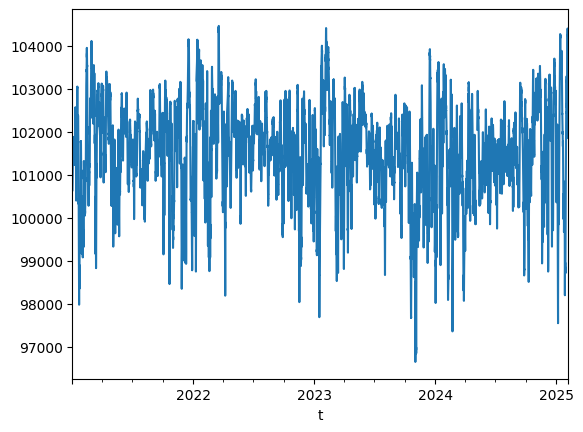

In [99]:
# correct for the air pressure fluctuations and drift in the instrument
# first we load the data and add it to the dataset
dfp = read_knmi_uurgeg(
    knmiFile,
    stationNumber)
dt = ((ds.t[1] - ds.t[0]) / np.timedelta64(1, 's')).values
pAir = dfp['P'].to_xarray().resample({'t': '{}S'.format(dt)}).interpolate('linear')
ds['pAir'] = pAir.sel(t=slice(ds.t.min(), ds.t.max()))

dfp.P.plot()
#print last time of dfp
print(dfp.index[-1])	

In [100]:
# correct for the air pressure fluctuations and drift in the instrument
# first we load the data and add it to the dataset
dfp = read_knmi_uurgeg(
    knmiFile,
    stationNumber)
dt = ((ds.t[1] - ds.t[0]) / np.timedelta64(1, 's')).values
pAir = dfp['P'].to_xarray().resample({'t': '{}S'.format(dt)}).interpolate('linear')
ds['pAir'] = pAir.sel(t=slice(ds.t.min(), ds.t.max()))

# we correct for drift in air pressure, nothing else
ds['dpAir'] = ds['pAir'] - ds['pAir'].isel(t=0)

# correct the pressure signal with dpAir and with drift in instrument pressure
ds['pc'] = ds['p'] - ds['dpAir']
ds['pc'].attrs = {'units': 'Pa + NAP', 'long_name': 'pressure', 'comments': 'drift in air pressure is corrected'}

ds['eta'] = ds['pc'] / rho / g + ds.zip
ds['eta'].attrs = {'units': 'm+NAP', 'long_name': 'hydrostatic water level'}

ds['zsmean'] = ds.eta.mean(dim='N')
ds['zsmean'].attrs = {'units': 'm + NAP', 'long_name': 'water level',
                      'comments': 'burst averaged'}

ds['h'] = ds.zsmean - zb
ds['h'].attrs = {'units': 'm', 'long_name': 'water column height'}

c:\Users\ruro\OneDrive - Boskalis\Documents\GitHub\HybridDune\Ruben\ADV\KNMI_readers.py:28: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  t0 = pd.to_datetime(knmi.iloc[0]['YYYYMMDD'],format='%Y%m%d')+pd.Timedelta('{}H'.format(knmi.iloc[0]['HH']))
c:\Users\ruro\OneDrive - Boskalis\Documents\GitHub\HybridDune\Ruben\ADV\KNMI_readers.py:29: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  t = pd.date_range(t0.to_datetime64(),periods=len(knmi),freq='1H')
c:\Users\ruro\AppData\Local\Programs\Python\Python39\lib\site-packages\xarray\groupers.py:326: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  self.index_grouper = pd.Grouper(


In [101]:
ds

<xarray.Dataset> Size: 874MB
Dimensions:   (t: 168, N: 28720)
Coordinates:
  * t         (t) datetime64[ns] 1kB 2024-12-16T13:00:00 ... 2024-12-23T12:00:00
  * N         (N) float64 230kB 0.0 0.125 0.25 ... 3.59e+03 3.59e+03 3.59e+03
    maskp     (t, N) bool 5MB True True True True False ... True True True True
    maskv     (t, N) bool 5MB False False False False ... False False False
Data variables: (12/50)
    sf        float64 8B ...
    p         (t, N) float64 39MB 1.14e+03 680.0 800.0 1.14e+03 ... 0.0 0.0 0.0
    u         (t, N) float64 39MB 1.683 0.184 1.028 ... -2.435 1.335 1.845
    v         (t, N) float64 39MB 1.074 0.536 -0.521 ... -1.116 -1.089 -0.22
    w         (t, N) float64 39MB -0.089 -0.097 0.198 ... -0.631 0.235 0.162
    anl1      (t, N) float64 39MB ...
    ...        ...
    pAir      (t) float64 1kB 1.03e+05 1.029e+05 ... 1.018e+05 1.018e+05
    dpAir     (t) float64 1kB 0.0 -30.0 -60.0 ... -1.23e+03 -1.16e+03 -1.14e+03
    pc        (t, N) float64 39MB 1.14e+03 680.0 800.0 ... 1.14e+03 1.14e+03
    eta       (t, N) float64 39MB 0.3834 0.3376 0.3496 ... 0.3834 0.3834 0.3834
    zsmean    (t) float64 1kB 0.3488 0.3452 0.3459 ... 0.4198 0.3867 0.3843
    h         (t) float64 1kB 0.3488 0.3452 0.3459 ... 0.4198 0.3867 0.3843
Attributes: (12/15)
    Conventions:               CF-1.6
    title:                     ADV_RWS1_Deployment1
    instrument:                vec1
    instrument serial number:  16725
    epsg:                      28992
    x:                         117196.6
    ...                        ...
    summary:                   December pilot field campaign
    contact person:            Marlies van der Lugt
    emailadres:                m.a.vanderlugt@tudelft.nl
    construction datetime:     12-Feb-2025 (09:22:33)
    version:                   v1
    version comments:          constructed with xarray

In [102]:

# #% rotate to ENU coordinates (this is only necessary if measurements were performed in XYZ
ufunc = lambda u,v: puv.rotate_velocities(u,v,thet-90)
ds['u'],ds['v'] = xr.apply_ufunc(ufunc,
                    ds['u'], ds['v'],
                    input_core_dims=[['N'], ['N']],
                    output_core_dims=[['N'],['N']],
                    vectorize=True)
ds['u'].attrs = {'units':'m/s','long_name':'velocity E'}
ds['v'].attrs = {'units':'m/s','long_name':'velocity N'}
ds['w'].attrs = {'units':'m/s','long_name':'velocity U'}

# remove pressure observations where the estimated water level is
# lower than the sensor height with margin of error of 10 cm
ds.coords['maskd'] = (('t', 'N'), zb+hi < (ds['eta'].values - 0.05))
ds[['u','v','w','p','pc','eta']] = ds[['u','v','w','p','pc','eta']].where(ds.maskp == True)
ds[['u','v','w','p','pc','eta']] = ds[['u','v','w','p','pc','eta']].where(ds.maskd == True)
ds[['u','v','w','p','pc','eta']] = ds[['u','v','w','p','pc','eta']].where(ds.maskv == True)

# ammending the meta data to add extra info
ds.attrs['version'] = 'v2'
ds.attrs['coordinate type'] = 'ENU'
ds.attrs['comment'] = 'Quality checked data: pressure reference level corrected for airpressure drift,' + \
                 r'correlation and amplitude checks done and spikes were removed. ' + \
                 r'Velocities rotated to ENU coordinates based on heading and configuration in the field.'

# save to netCDF wwhere we don't include the sen data any more because we have only used it for the quality check
ds = ds.drop(['a1', 'a2', 'a3',
              'cor1', 'cor2', 'cor3',
              'snr1', 'snr2', 'snr3',
              'heading', 'pitch', 'roll',
              'voltage', 'pc'])

# specify compression for all the variables to reduce file size
comp = dict(zlib=True, complevel=5)
ds.encoding = {var: comp for var in ds.data_vars}



ncOutDir = r"C:\Users\ruro\OneDrive - Boskalis\Documents\python\Hybrid_Dune\ADV\Deployment 1, until 23dec\QC"
if not os.path.exists(ncOutDir):
    os.mkdir(ncOutDir)
ds.to_netcdf(os.path.join(ncOutDir, 'vec1.nc'), encoding=ds.encoding)

C:\Users\ruro\AppData\Local\Temp\ipykernel_22740\3484801007.py:27: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  ds = ds.drop(['a1', 'a2', 'a3',


In [103]:
ds

<xarray.Dataset> Size: 338MB
Dimensions:   (t: 168, N: 28720)
Coordinates:
  * t         (t) datetime64[ns] 1kB 2024-12-16T13:00:00 ... 2024-12-23T12:00:00
  * N         (N) float64 230kB 0.0 0.125 0.25 ... 3.59e+03 3.59e+03 3.59e+03
    maskp     (t, N) bool 5MB True True True True False ... True True True True
    maskv     (t, N) bool 5MB False False False False ... False False False
    maskd     (t, N) bool 5MB False False False False ... False False False
Data variables: (12/36)
    sf        float64 8B ...
    p         (t, N) float64 39MB nan nan nan nan nan ... nan nan nan nan nan
    u         (t, N) float64 39MB nan nan nan nan nan ... nan nan nan nan nan
    v         (t, N) float64 39MB nan nan nan nan nan ... nan nan nan nan nan
    w         (t, N) float64 39MB nan nan nan nan nan ... nan nan nan nan nan
    anl1      (t, N) float64 39MB ...
    ...        ...
    md        (t, N) bool 5MB True True True True False ... True True True True
    pAir      (t) float64 1kB 1.03e+05 1.029e+05 ... 1.018e+05 1.018e+05
    dpAir     (t) float64 1kB 0.0 -30.0 -60.0 ... -1.23e+03 -1.16e+03 -1.14e+03
    eta       (t, N) float64 39MB nan nan nan nan nan ... nan nan nan nan nan
    zsmean    (t) float64 1kB 0.3488 0.3452 0.3459 ... 0.4198 0.3867 0.3843
    h         (t) float64 1kB 0.3488 0.3452 0.3459 ... 0.4198 0.3867 0.3843
Attributes: (12/16)
    Conventions:               CF-1.6
    title:                     ADV_RWS1_Deployment1
    instrument:                vec1
    instrument serial number:  16725
    epsg:                      28992
    x:                         117196.6
    ...                        ...
    contact person:            Marlies van der Lugt
    emailadres:                m.a.vanderlugt@tudelft.nl
    construction datetime:     12-Feb-2025 (09:22:33)
    version:                   v2
    version comments:          constructed with xarray
    comment:                   Quality checked data: pressure reference level...

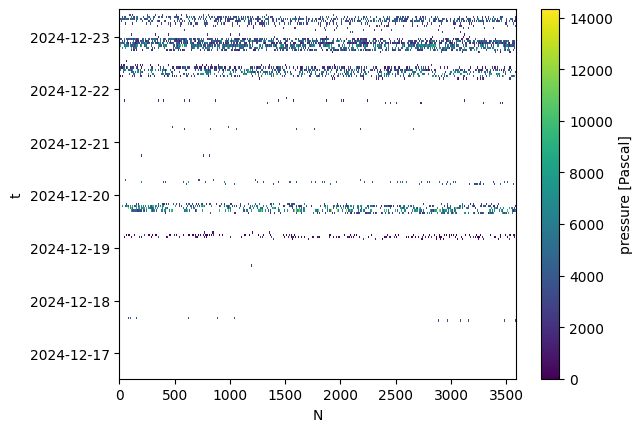

In [104]:
ds.p.plot()

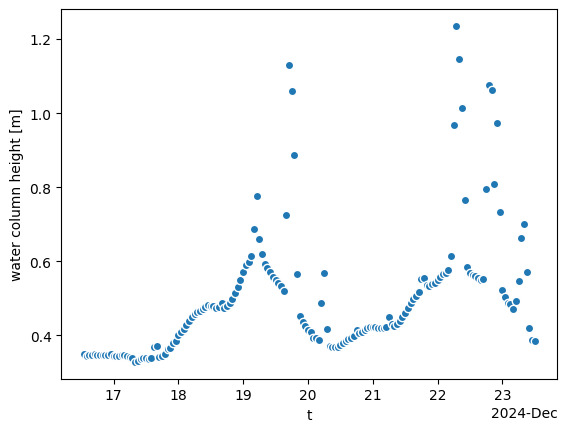

In [105]:
ds.h.plot.scatter()

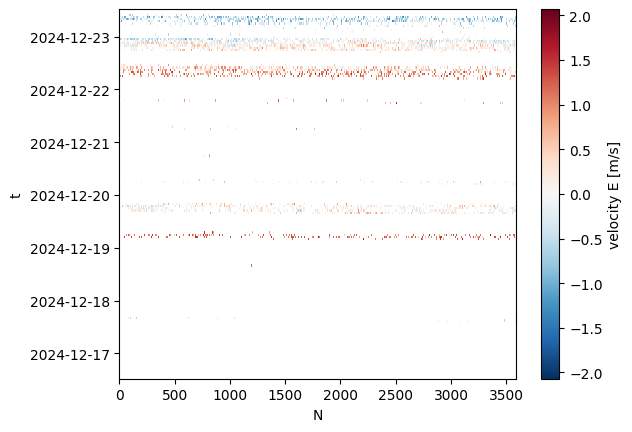

In [106]:
ds.u.plot()